# 1 - Defining the Questions

Within this project, we hope to answer the following questions:

- How does the average number of video game sales vary by genre?
- Which of the following factors (platform, publisher, genre, release year) most strongly predict a game's global sales and success worldwide?
- What regional sales patterns (if any) developed in the different markets of North America, Europe, Japan, etc.?
- How well does a given year predict the total number of sales?

These questions aim to uncover patterns in the video game sales dataset which can be used in the future for predictions within the video game sales market.





# 2 - Data Collection

**Data Source**: Kaggle dataset (https://www.kaggle.com/datasets/gregorut/videogamesales?resource=download) which was originally scraped from VGChartz.com

**Limitations**: This only covers *physical* copies of video game sales, which excludes mobile/digital sales.

**Predictors**: Name, Platform, Year, Genre, Publisher, North American Sales, European Sales, Japanese Sales, Other Sales, Global Sales (Also "Rank", the auto-assigned key value assigned in decending order of "Global Sales"). Sales are in millions of units for scale.

The data was collected upon games which were released from 1980-2020, with most entries being from either 2008 (9%) or 2009 (9%)

# 3 - Data Cleaning and Preparation

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import multivariate_t
from sklearn.linear_model import LinearRegression

In [ ]:
from google.colab import files
uploaded = files.upload()

data = pd.read_csv('vgsales.csv')
data.head(10)

data['Publisher'] = data['Publisher'].fillna('Unknown') #fill null values of publisher with 'Unknown' - since this is already a data entry in this dataset.
# Fill missing years with the publisher's average year
data['Year'] = data['Year'].fillna(data.groupby(['Platform'])['Year'].transform('mean'))
# Round the years
data['Year'] = data['Year'].round()
# Convert to integer (nullable Int64 so that any remaining NaNs are okay)
data['Year'] = data['Year'].astype('Int64')

# feature engineering: creating a decades feature
data['Decade'] = (data['Year'] // 10 * 10).astype('Int64').astype(str) + 's'
data = data[data['Decade'] != '2020s'] # there is only one (1) game in this dataset from the 2020s


data.head()

Saving vgsales.csv to vgsales.csv


,Rank,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Decade
0,1,Wii Sports,Wii,2006,Sports,Nintendo,41.49,29.02,3.77,8.46,82.74,2000s
1,2,Super Mario Bros.,NES,1985,Platform,Nintendo,29.08,3.58,6.81,0.77,40.24,1980s
2,3,Mario Kart Wii,Wii,2008,Racing,Nintendo,15.85,12.88,3.79,3.31,35.82,2000s
3,4,Wii Sports Resort,Wii,2009,Sports,Nintendo,15.75,11.01,3.28,2.96,33.00,2000s
4,5,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,Nintendo,11.27,8.89,10.22,1.00,31.37,1990s


In [ ]:
#Used to check no null values left in data set

#data.isnull().sum()
#data[data['Year'].isnull()].head()
#data.shape #this is the original size of data set



We replaced unknown values of publisher with 'Unknown', in order to fill the NaN values in the publisher column. Since 'Unknown was already a data entry in this column for some of the entries, it made the most sense to group the missingness with 'Unknown', should we group analysis based off this. We also replaced the missing 'Year' values with the mean year of its publisher. Each platform has its' mean release year, and that mean was filled in for the missing year value. For example, Wii had an average release year of 2008, so every entry that was a Wii platform that was missing a Year value was filled with 2008, and so forth. All other columns were checked and did not additional processing. The data is cleaned and we are ready to proceed with our analysis!

# 4 - Data Analysis

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance
from sklearn.preprocessing import StandardScaler

# ** this may take a few minutes to run

# load and clean
data['Publisher'] = data['Publisher'].fillna('Unknown')
data['Year'] = (
    data['Year']
    .fillna(data.groupby('Platform')['Year'].transform('mean'))
    .round()
    .astype('Int64')
)
data = data.dropna(subset=['Global_Sales'])

# feature engineering
# keep top 20 publishers, lump rest as "Other"
top_pubs = data['Publisher'].value_counts().nlargest(20).index
data['Publisher_top20'] = data['Publisher'].where(
    data['Publisher'].isin(top_pubs), other='Other'
)

# one hot encoding
X = pd.get_dummies(
    data[['Platform','Genre','Publisher_top20']],
    drop_first=True
)

# add year as numeric feature
X['Year'] = data['Year'].astype(int)

y = data['Global_Sales']

# train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# fit random forest
rf = RandomForestRegressor(
    n_estimators=200,
    random_state=42,
    n_jobs=-1
)
rf.fit(X_train, y_train)

# permutation importance
perm_imp = permutation_importance(
    rf, X_test, y_test,
    n_repeats=10,
    random_state=42,
    n_jobs=-1
)

# gather and sort
perm_series = pd.Series(
    perm_imp.importances_mean,
    index=X.columns
).sort_values(ascending=False)

print("Top 10 Permutation Importances:")
print(perm_series.head(10))

Top 10 Permutation Importances:
Publisher_top20_Nintendo                0.129355
Genre_Racing                            0.040512
Platform_Wii                            0.037938
Year                                    0.037166
Genre_Role-Playing                      0.022933
Genre_Sports                            0.012299
Genre_Shooter                           0.012229
Publisher_top20_Take-Two Interactive    0.010080
Publisher_top20_Electronic Arts         0.007607
Platform_X360                           0.007187
dtype: float64


**--> Which of the following factors (platform, publisher, genre, release year) most strongly predict a game's global sales and success worldwide?**

The factor that most strongly predicts a game's global sales and success is having Nintendo as its publisher.

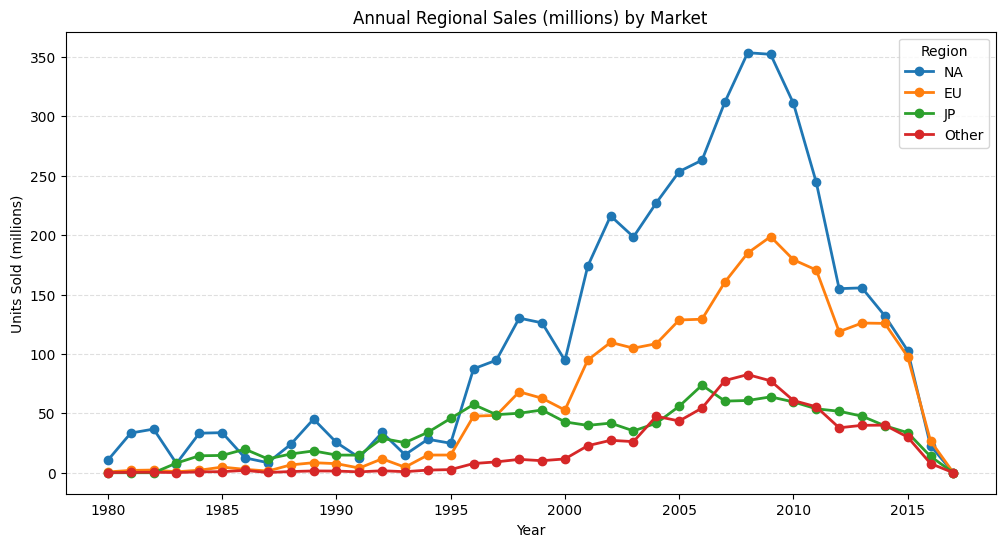

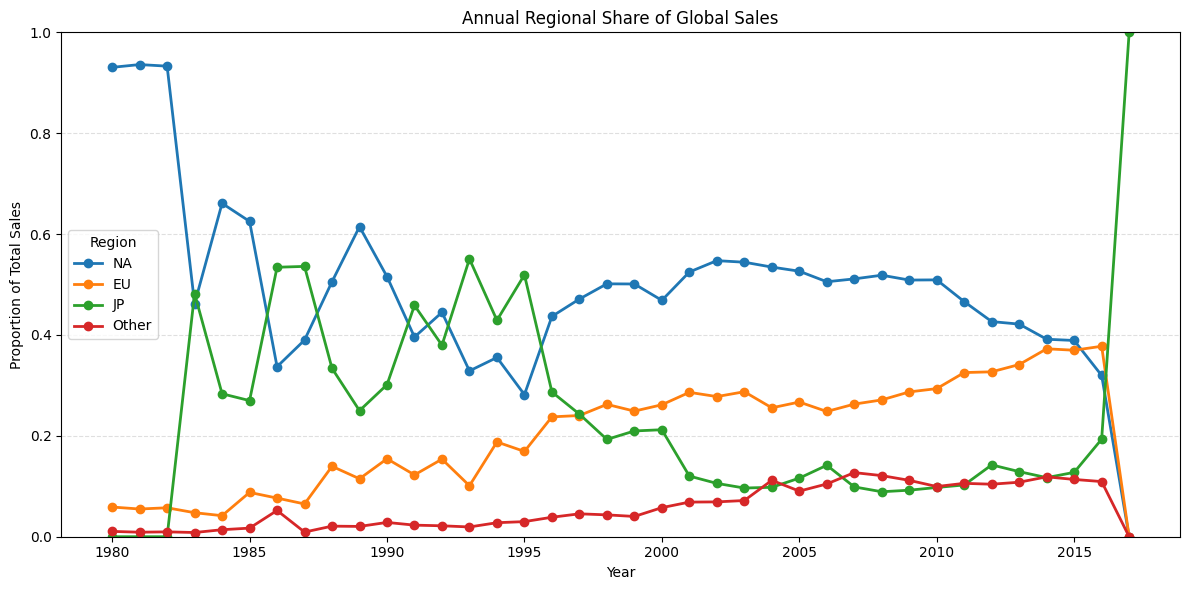

In [ ]:
# annual sums for each region
region_cols = ['NA_Sales','EU_Sales','JP_Sales','Other_Sales']
annual = data.groupby('Year')[region_cols].sum()

# absolute sales
fig, ax = plt.subplots(figsize=(12,6))
for col in region_cols:
    ax.plot(
        annual.index,
        annual[col],
        marker='o',
        linewidth=2,
        label=col.replace('_Sales','')
    )
ax.set_title("Annual Regional Sales (millions) by Market")
ax.set_xlabel("Year")
ax.set_ylabel("Units Sold (millions)")
ax.legend(title="Region")
ax.grid(True, axis='y', linestyle='--', alpha=0.4)

# compute and plot regional share of global sales
share = annual.div(annual.sum(axis=1), axis=0)
fig, ax = plt.subplots(figsize=(12,6))
for col in region_cols:
    ax.plot(
        share.index,
        share[col],
        marker='o',
        linewidth=2,
        label=col.replace('_Sales','')
    )
ax.set_title("Annual Regional Share of Global Sales")
ax.set_xlabel("Year")
ax.set_ylabel("Proportion of Total Sales")
ax.set_ylim(0,1)
ax.legend(title="Region")
ax.grid(True, axis='y', linestyle='--', alpha=0.4)

plt.tight_layout()
plt.show()

**--> What regional sales patterns (if any) developed in the different markets of North America, Europe, Japan, etc.?**

The North America and European Union markets tend to dominate video game sales in terms of sheer volume due to their relatively higher populations, and therefore a larger potential customer base. In terms of the regional share of global sales, Japan suddenly saw a large spike from the years 2016-2017 which may be explained by popular or long-anticipated video games being released.

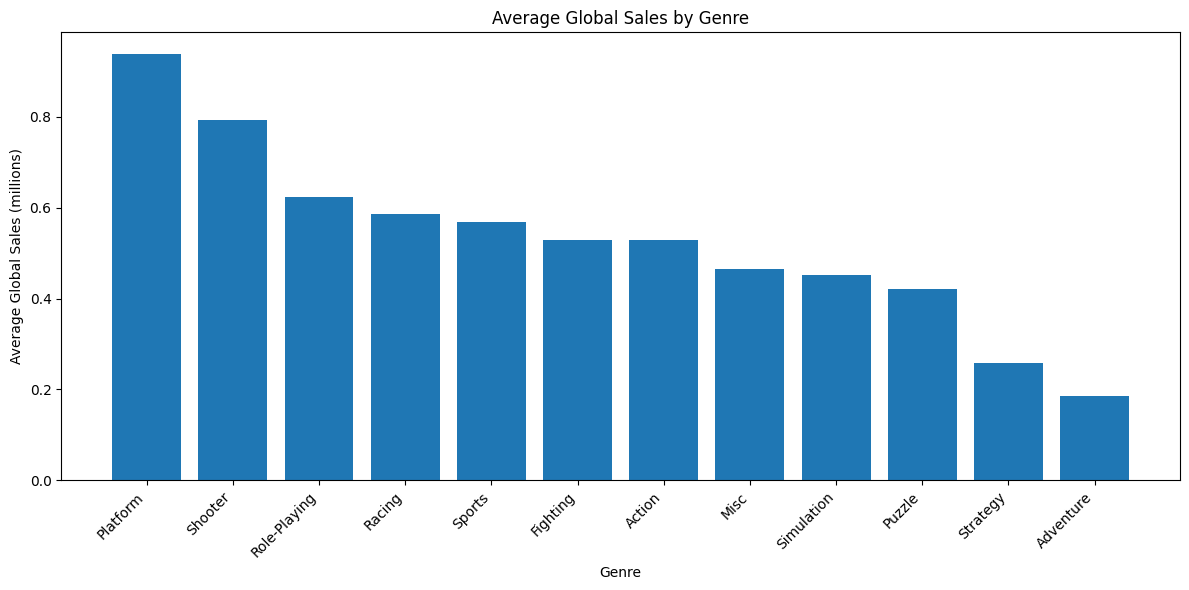

In [ ]:
genre_mean = data.groupby('Genre')['Global_Sales'] \
                 .mean() \
                 .sort_values(ascending=False)

plt.figure(figsize=(12,6))
plt.bar(genre_mean.index, genre_mean.values)
plt.xticks(rotation=45, ha='right')
plt.title("Average Global Sales by Genre")
plt.xlabel("Genre")
plt.ylabel("Average Global Sales (millions)")
plt.tight_layout()
plt.show()

**-->  How does the average number of video game sales vary by genre?**

Genres such as Platformers and Shooters had the highest average global sales, which could be due in part to the popularity of franchises such as Mario and Sonic for platformers and the Call of Duty franchise for shooters for additional context.

True slope (coefficient): -0.0198
[-0.0274 -0.015  -0.0224 -0.017  -0.0205 -0.0231 -0.0236 -0.019  -0.0165
 -0.0135]


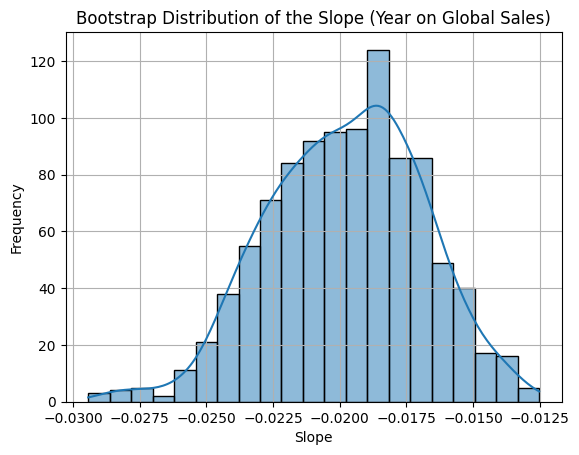

95% confidence interval for slope: [-0.0253, -0.0143]


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression

# 1. Prepare data
sales_data = data[['Year', 'Global_Sales']]
X = sales_data['Year'].values.reshape(-1, 1)
y = sales_data['Global_Sales'].values

# Fit linear regression
model = LinearRegression()
model.fit(X, y)

# Print true slope
print(f"True slope (coefficient): {model.coef_[0]:.4f}")

# 2. Bootstrap function
def bootstrap_slope(X, y, num_samples=1000):
    slopes = []
    n = len(X)
    for _ in range(num_samples):
        indices = np.random.choice(n, n, replace=True)
        X_bootstrap = X[indices]
        y_bootstrap = y[indices]

        model = LinearRegression().fit(X_bootstrap, y_bootstrap)
        slopes.append(model.coef_[0])  # Save slopes

    return np.array(slopes)

# 3. Run bootstrap
slopes = bootstrap_slope(X, y, num_samples=1000)
print(slopes[:10].round(4))

# 4. Plot
sns.histplot(slopes, kde=True)
plt.title("Bootstrap Distribution of the Slope (Year on Global Sales)")
plt.xlabel("Slope")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

# 5. Confidence Interval
lower = np.percentile(slopes, 2.5)
upper = np.percentile(slopes, 97.5)
print(f"95% confidence interval for slope: [{lower:.4f}, {upper:.4f}]")


We use bootstrapping to predict the slope of our regression model. We use years to predict global sales, and compare it with the confidence interval made with the bootstrap method.The true slope is -0.019, which isn't much, but the negative slope does imply that the year has some predictive power. The confidence interval *not* including zero supports that. Also, the confidence interval is not super wide, supporting a claim that the data is stable. Overall, the year, although not huge, does have some predictive power in estimating the global sales. This ties back to one of our questions in part one, answering that year is a variable that can help predict global sales.

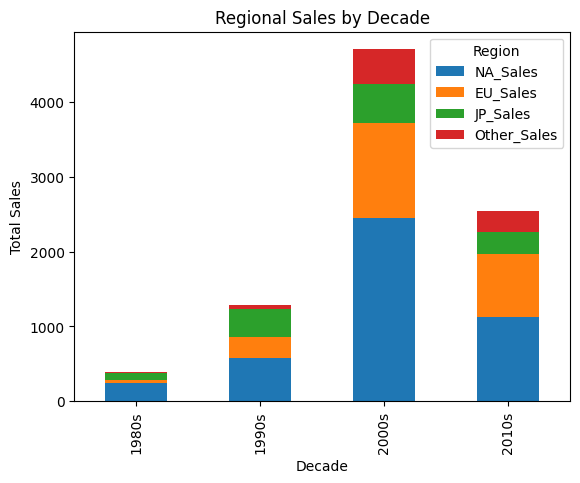

In [ ]:
region_cols = ["NA_Sales","EU_Sales","JP_Sales","Other_Sales"]
dec_reg = data.groupby("Decade")[region_cols].sum()
dec_reg.plot(kind="bar", stacked=True)
plt.title("Regional Sales by Decade")
plt.xlabel("Decade")
plt.ylabel("Total Sales")
plt.legend(title="Region")
plt.show()

Our Regional Sales by Decade graph addresses our question surrounding the regional sales pattern over time. We clearly see that all regions follow a similar trend, with sales rapidly growing from the 80’s until a peak in the 2000’s during a boom in video games, before taking a step back in the 2010’s. Despite all following the same pattern, it is evident that North American sales were the most drastically impacted throughout the decades.

NA_Sales on Mean slope: 1.7922, 95% CI: [1.6500, 1.9281]
EU_Sales on Mean slope: 2.7739, 95% CI: [2.6438, 2.8939]
JP_Sales on Mean slope: 3.0616, 95% CI: [2.6331, 3.5917]
Other_Sales on Mean slope: 6.3485, 95% CI: [4.5524, 8.2528]


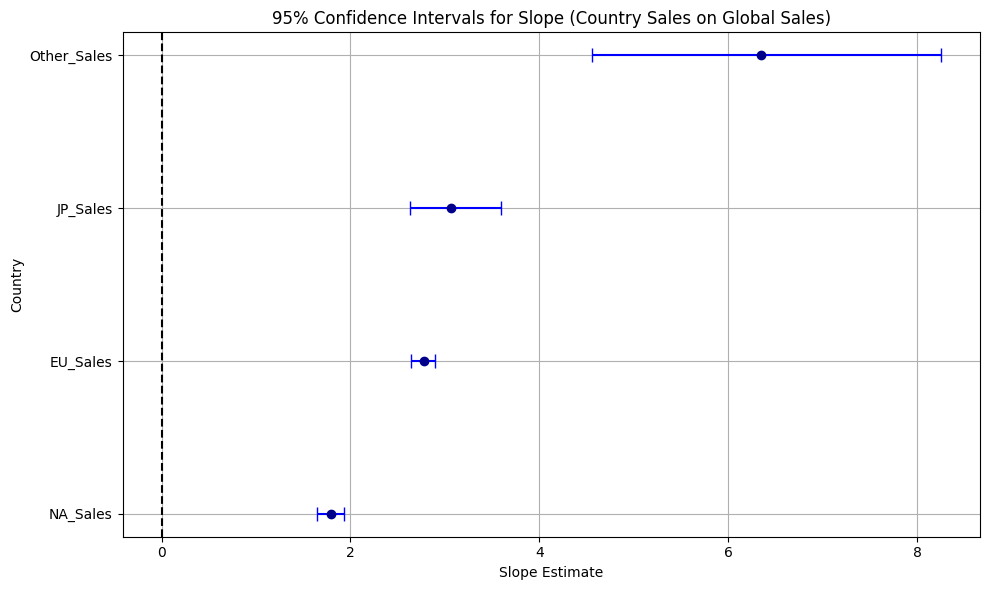

In [ ]:
#which country is the best predictor for total global sales (which has the best impact in regression)

def bootstrap_slope(X, y, n_bootstrap=1000):
    slopes = []
    n = len(X)
    for _ in range(n_bootstrap):
        index = np.random.choice(n, n, replace=True)
        X_sample = X[index].reshape(-1, 1)
        y_sample = y[index]
        model = LinearRegression().fit(X_sample, y_sample)
        slopes.append(model.coef_[0])
    return np.percentile(slopes, [2.5, 97.5]), np.mean(slopes)

cols = ['Global_Sales', 'NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales']
df = data[cols].reset_index(drop=True)
results = {}

#Apply bootstrap

for country in ['NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales']:
    X = df[country].values
    y = df['Global_Sales'].values
    ci, slopes_mean = bootstrap_slope(X, y)
    results[country] = (slopes_mean, ci)
    print(f"{country} on Mean slope: {slopes_mean:.4f}, 95% CI: [{ci[0]:.4f}, {ci[1]:.4f}]")

#Plot CIs
countries = list(results.keys())
mean_slopes = [results[i][0] for i in countries]
lower_bounds = [results[i][1][0] for i in countries]
upper_bounds = [results[i][1][1] for i in countries]
errors = [[mean - low for mean, low in zip(mean_slopes, lower_bounds)],
          [high - mean for high, mean in zip(upper_bounds, mean_slopes)]]

# Plot
plt.figure(figsize=(10, 6))
plt.errorbar(mean_slopes, countries, xerr=errors, fmt='o', capsize=5, color='darkblue', ecolor='blue')
plt.axvline(0, color='black', linestyle='--')
plt.title('95% Confidence Intervals for Slope (Country Sales on Global Sales)')
plt.xlabel('Slope Estimate')
plt.ylabel('Country')
plt.grid(True)
plt.tight_layout()
plt.show()


Here we used bootstrapping to find which country had the biggest impact on predicting total global sales. Obviouslt total global sales is the sum of these four, but looking at them individually we watned to see which one could predict global sales the best, or had the biggest weight on the regression line. North American had the lowest sales, but the narrowest confidence interval. There is some proportionality to how many sales each country had and their overall weight on predicting global sales. EU had the next slope mean, but its entire confidence interval fell in between that of Japan'. Other sales grouped in everything else and had the largest sample size, so it makes sense that not only they had the greatest slope estimate, but also the most variability. This graph also helps answer one of our questions from Section 1. By breaking down by country sales and how each impacts the global sales, we can see the individual effects on regression.

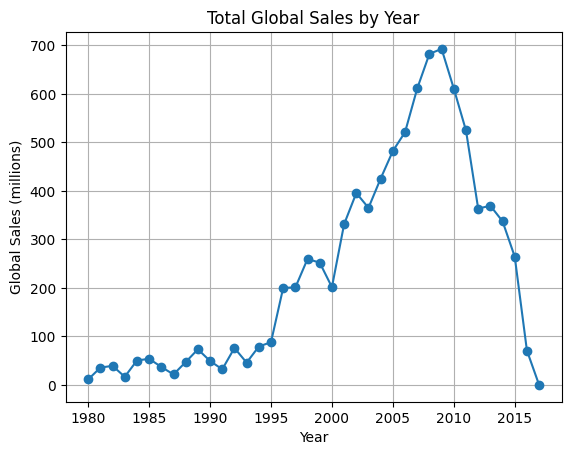

In [ ]:
# annual total sales per year
annual = data.groupby('Year')['Global_Sales'].sum()
plt.figure()
plt.plot(annual.index, annual.values, marker='o')
plt.title("Total Global Sales by Year")
plt.xlabel("Year")
plt.ylabel("Global Sales (millions)")
plt.grid(True)
plt.show()

Perhaps the data is incomplete or hasn't been updated as of recently, but the drop off post 2009 is shocking. The growth from 1980 to 2010 was constant until a spike shot up growth, but thirty years of increasing sales shot down in five. Another potential explanation is that this dataset only includes *physical* copies of video games sold, which excludes mobile and digital copies of video games which started to grow in popularity starting from the 2010s due to distributors such as Steam.

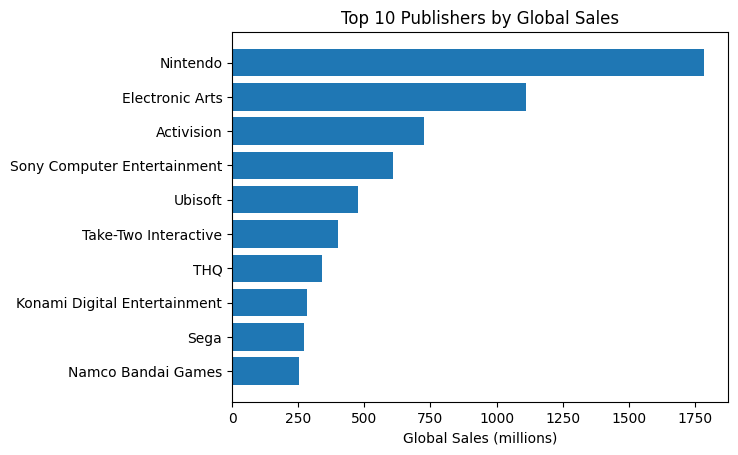

In [ ]:
# top (10) publishers by global sales
top_pub = data.groupby('Publisher')['Global_Sales'].sum().sort_values(ascending=True).tail(10)
plt.figure()
plt.barh(top_pub.index, top_pub.values)
plt.title("Top 10 Publishers by Global Sales")
plt.xlabel("Global Sales (millions)")
plt.show()

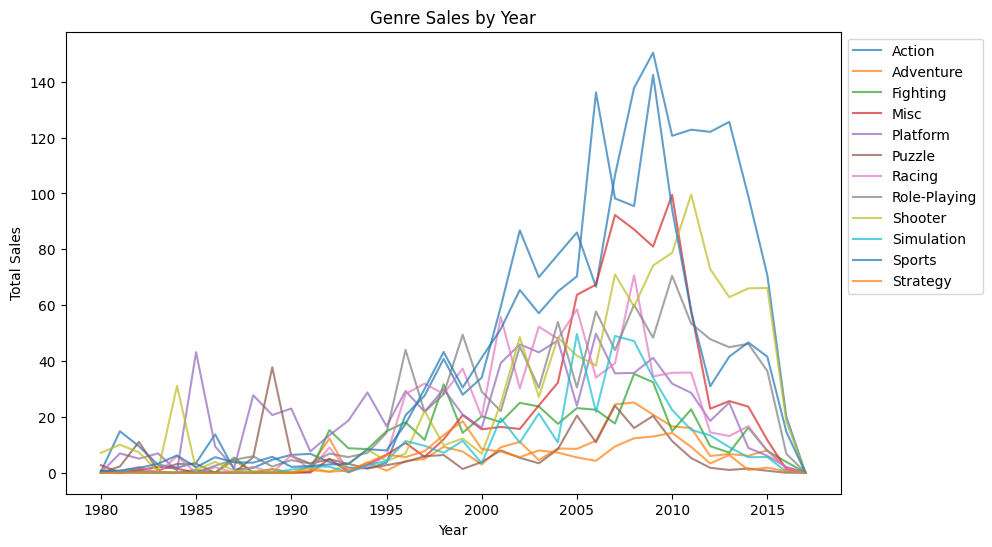

In [ ]:
# genre trends over time
genre_year = data.pivot_table(index='Year', columns='Genre',
                              values='Global_Sales', aggfunc='sum').fillna(0)
plt.figure(figsize=(10,6))
for g in genre_year.columns:
    plt.plot(genre_year.index, genre_year[g], label=g, alpha=0.7)
plt.legend(loc='upper left', bbox_to_anchor=(1.0,1))
plt.title("Genre Sales by Year")
plt.xlabel("Year")
plt.ylabel("Total Sales")
plt.show()

What's neat about this graph is that they all have a similar distribution and follow the trend from the above graph "Toal Sales by Year".

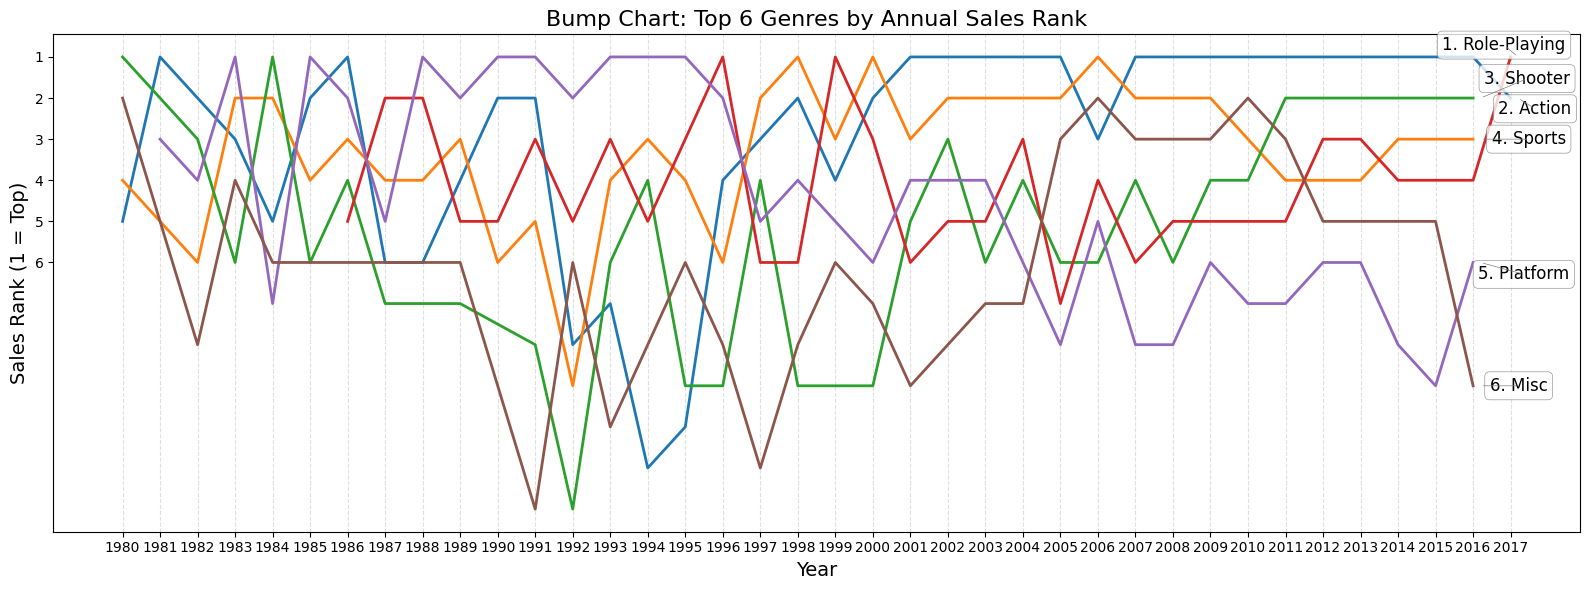

In [ ]:

!pip install adjustText

import matplotlib.pyplot as plt
from adjustText import adjust_text

genre_rank = (
    data
      .groupby(['Year','Genre'])['Global_Sales']
      .sum()
      .reset_index()
)
genre_rank['Rank'] = (
    genre_rank
      .groupby('Year')['Global_Sales']
      .rank(ascending=False, method='first')
)

# get only top 6 dengres
genre_totals = data.groupby('Genre')['Global_Sales'].sum()
top_genres = genre_totals.nlargest(6).index.tolist()
df = genre_rank[genre_rank['Genre'].isin(top_genres)]

fig, ax = plt.subplots(figsize=(16, 6))
for genre in top_genres:
    grp = df[df['Genre'] == genre]
    ax.plot(
        grp['Year'], grp['Rank'],
        markersize=8, linewidth=2
    )

ax.invert_yaxis()
ax.grid(axis='x', linestyle='--', alpha=0.4)
ax.set_xticks(sorted(df['Year'].unique()))
ax.set_yticks(range(1, len(top_genres) + 1))
ax.set_xlabel("Year", fontsize=14)
ax.set_ylabel("Sales Rank (1 = Top)", fontsize=14)
ax.set_title("Bump Chart: Top 6 Genres by Annual Sales Rank", fontsize=16)

last_pts = df.loc[df.groupby('Genre')['Year'].idxmax()].set_index('Genre')

# sort top_genres by their final rank
final_order = (
    last_pts.loc[top_genres]
           .sort_values('Rank')
           .index
           .tolist()
)

texts = []
x_offset = 0.2
for i, genre in enumerate(final_order, start=1):
    row = last_pts.loc[genre]
    label = f"{i}. {genre}"
    txt = ax.text(
        row['Year'] + x_offset,
        row['Rank'],
        label,
        va='center',
        fontsize=12,
        bbox=dict(
            boxstyle="round,pad=0.3",
            facecolor="white",
            edgecolor="gray",
            linewidth=0.5,
            alpha=0.8
        )
    )
    texts.append(txt)

# auto adjust to avoid overlap
adjust_text(
    texts,
    only_move={'points':'y', 'texts':'y'},
    arrowprops=dict(arrowstyle='-', color='gray', lw=0.5),
    expand_text=(1.05, 1.2),
    expand_points=(1.2, 1.2)
)

# drop legend
if ax.get_legend(): ax.get_legend().remove()

plt.tight_layout()
plt.show()

# 5 - Interpretation and Reporting

- Included beneath graphs

# 6 - Contributions

All group members equally contributed to the completion and success of the project by participating in various roles. Cale primarily contributed in the sections Defining the Questions, Data Cleaning and Preparation, Interpretation and Reporting of the Data Analysis, and Reproducability, as well as assisting in the Presentation Slides. Kendall primarily contributed in the Data Analysis portion, as well as assisting in the Data Cleaning and Preparation, and Interpretation and Reporting, and will assist in the Presentation Slides. Kiratiya primarily contributed in the Data Analysis portion as well, and assisted in Defining the Questions and Data Collection. She also intends to be primarily responsible for the Presentation slides. Naturally, all members intend to, and have thus far, helped their group mates as needed to ensure a final product which all members are fully satisfied with.